In [3]:
from subprocess import Popen, DEVNULL
import time
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
def run(sz, ns):
    writer = Popen(['./writer', str(sz), str(ns)], stdout=DEVNULL, stderr=DEVNULL)
    time.sleep(1)
    reader = Popen(['./reader', str(sz)], stdout=DEVNULL, stderr=DEVNULL)
    writer.wait()
    reader.wait()

def fromFile(filename):
    times = []
    with open(filename) as f:
        for l in f:
            times.append(int(l.rstrip('\n')))
    return np.array(times)

# Описание
В моей реализации RingBuffer сделано две "возможных" оптимизации:
1) Локальная версия счетчика (не требует обращения к атомику в разделяемой памяти)
2) Обновление атомика в разделяемой памяти не после каждого прочитанного/записанного объекта, а после накопления некоторого батча

команды компиляции см ниже

-DBATCH_SIZE=n - установить размер батча (пункт 2), по умолчанию равен 1

-DRING_BUFFER_SIZE=n - установить размер буффера, 1024 по умолчанию

In [ ]:
! clang++ -std=c++17 -O3 writer.cpp -o writer
! clang++ -std=c++17 -O3 reader.cpp -o reader

./writer count period - запись count сообщений раз в period

./reader count - чтение count сообщений

# Анализ
# 1
Для начала проанализируем зависимость задержки от частоты записи данных с базовыми параметрами буффера:
размер батча из пункта 2 равен единице - то есть по сути оптимизация отсутствует

In [43]:
sz = 2**7
ns = 2**27

x = []
y = []
while True:
    print(f'Running sz={sz}, ns={ns}')
    run(sz, ns)
    w = fromFile('writer.txt')
    r = fromFile('reader.txt')
    res = r - w
    x.append(ns)
    y.append(np.percentile(res, 99))
    if ns == 0:
        break
    ns //= 4
    if sz < 10**5:
        sz *= 4

Running sz=128, ns=134217728
Running sz=512, ns=33554432
Running sz=2048, ns=8388608
Running sz=8192, ns=2097152
Running sz=32768, ns=524288
Running sz=131072, ns=131072
Running sz=131072, ns=32768
Running sz=131072, ns=8192
Running sz=131072, ns=2048
Running sz=131072, ns=512
Running sz=131072, ns=128
Running sz=131072, ns=32
Running sz=131072, ns=8
Running sz=131072, ns=2
Running sz=131072, ns=0


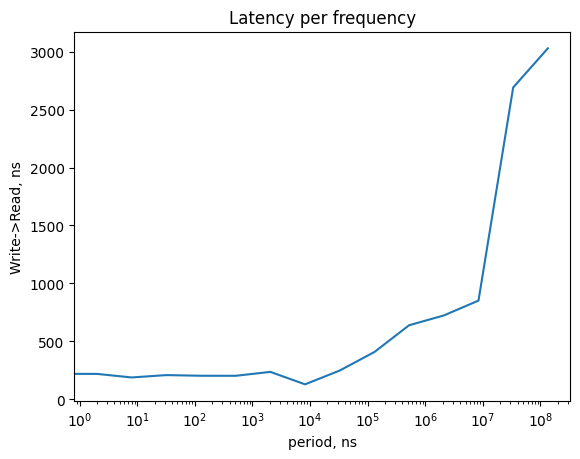

In [44]:
plt.plot(x, y)
plt.xlabel('period, ns')
plt.ylabel('Write->Read, ns')
plt.title('Latency per frequency')
plt.xscale("log")

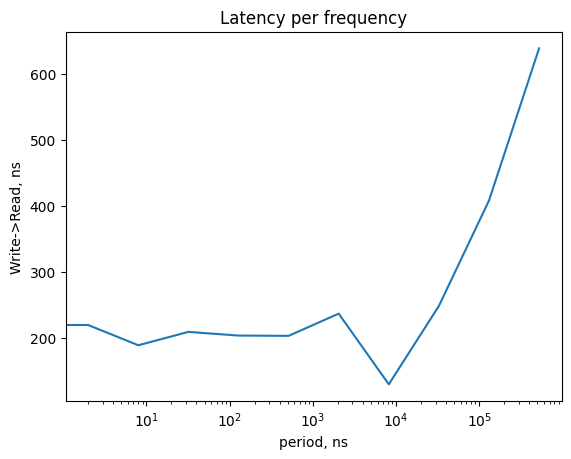

In [45]:
plt.plot(x[4:], y[4:])
plt.xlabel('period, ns')
plt.ylabel('Write->Read, ns')
plt.title('Latency per frequency')
plt.xscale("log")

# Вывод
Видим, что задержка остается +-постоянной около 200ns, а при больших периодах записи резко увеличивается (на это также влият меньший размер выборки в запусках с большим периодом для экономии времени)

# 2
Посмторим на время между соседними записями

Text(0.5, 1.0, 'Write to write diff')

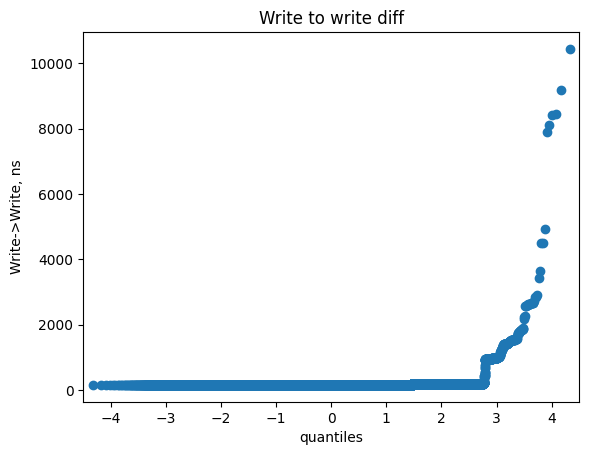

In [46]:
import statsmodels.api as sm
w = fromFile('writer.txt')
r = fromFile('reader.txt')
fig = sm.qqplot(w[1:] - w[:-1])

plt.ylabel('Write->Write, ns')
plt.xlabel('quantiles')
plt.title('Write to write diff')

In [47]:
np.percentile(w[1:] - w[:-1], 50)

163.0

# Вывод
При обще задержке в 200ns нецелесообразно использовать батчи на запись
Иллюстрирую:

In [50]:
batch_sizes = [1, 2, 5, 10, 15, 16, 24]
latency99 = []
sz = 10**5
ns = 0 

for batch_size in batch_sizes:
    os.system(f'clang++ -std=c++17 -O3 writer.cpp -o writer -DBATCH_SIZE={batch_size}')
    os.system(f'clang++ -std=c++17 -O3 reader.cpp -o reader')
    print(f'Running batch_size={batch_size}')
    run(sz, ns)
    w = fromFile('writer.txt')
    r = fromFile('reader.txt')
    res = r - w
    latency99.append(np.percentile(res, 99))

Running batch_size=1
Running batch_size=2
Running batch_size=5
Running batch_size=10
Running batch_size=15
Running batch_size=16
Running batch_size=24


Text(0.5, 1.0, 'Latency per Writer Batch Size')

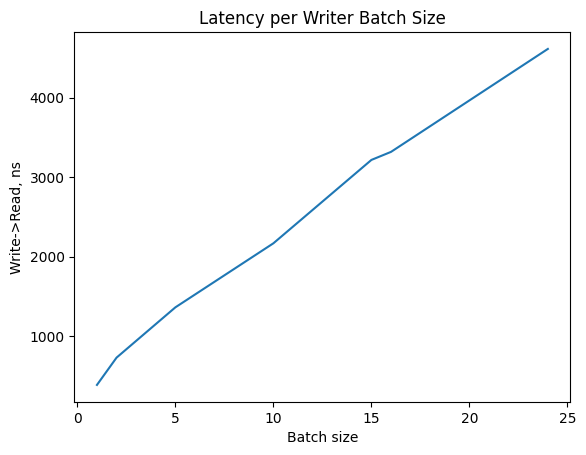

In [52]:
plt.plot(batch_sizes, latency99)
plt.xlabel('Batch size')
plt.ylabel('Write->Read, ns')
plt.title('Latency per Writer Batch Size')

Да, это мы и ожидали увидеть - линейная зависимость от размера батча.
Также видна особенность при BatchSize=16, это связано с тем что 16 * sizeof(uint32_t) = кэш линия!

# 3
Разберемся с BatchSize читателя:
Идейно - выгодно поставить BatchSize близкий к размеру всего буффера чтобы реже обновлять shared счетчик
Но думаю, даже если мы успеваем вычитывать объекты, то это может и не приносить выигрыша, так как писатель уже (с помощью оптимизации 1) редко обращается к shared счетчик и он почти всегда находится в кэше читателя (а при батч подходе он даже может вытесниться оттуда)

In [142]:
batch_sizes = [1, 2, 16, 64, 128, 256, 512, 1024 - 32, 1024 - 16, 1024 - 1]
latency99 = []
sz = 10**5
ns = 0 

for batch_size in batch_sizes:
    os.system(f'clang++ -std=c++17 -O3 writer.cpp -o writer')
    os.system(f'clang++ -std=c++17 -O3 reader.cpp -o reader -DBATCH_SIZE={batch_size}')
    print(f'Running batch_size={batch_size}')
    run(sz, ns)
    w = fromFile('writer.txt')
    r = fromFile('reader.txt')
    res = r - w
    latency99.append(np.percentile(res, 99))

Running batch_size=1
Running batch_size=2
Running batch_size=16
Running batch_size=64
Running batch_size=128
Running batch_size=256
Running batch_size=512
Running batch_size=992
Running batch_size=1008
Running batch_size=1023


Text(0.5, 1.0, 'Latency per Reader Batch Size')

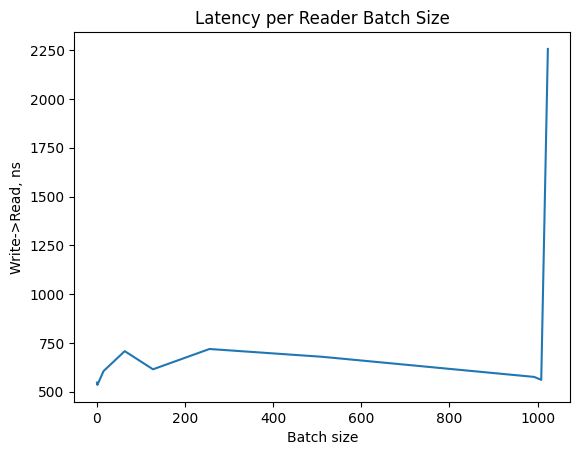

In [143]:
plt.plot(batch_sizes, latency99)
plt.xlabel('Batch size')
plt.ylabel('Write->Read, ns')
plt.title('Latency per Reader Batch Size')

# Вывод
Довольно наглядный график получаем: задержка с некотрого линейно уменьшается при увеличении размера батча (меньше обращений к памяти, но и ее нет в кэше). При BatchSize=1,2 - часто обновляем ячейку, она всегда в кэше. При BatchSize=RingBuffer-1 мы бывает не успеваем сообщить о вычитывании и соответственно тормозим запись след обьекта

Для дальнейшего сравнения оставляем BatchSize=1,(1024-16) так как имеют сравнимую задержку

# 4
Зависимость от частоты при разных размерах батча

In [176]:
sz = 10**5
ns = 2**17

x = []
y_b0 = []
y_bb = []

while True:
    os.system(f'clang++ -std=c++17 -O3 writer.cpp -o writer')
    os.system(f'clang++ -std=c++17 -O3 reader.cpp -o reader')
    x.append(ns)
    print(f'Running sz={sz}, ns={ns}')
    run(sz, ns)
    w = fromFile('writer.txt')
    r = fromFile('reader.txt')
    res = r - w
    y_b0.append(np.percentile(res, 99))

    os.system(f'clang++ -std=c++17 -O3 writer.cpp -o writer')
    os.system(f'clang++ -std=c++17 -O3 reader.cpp -o reader -DBATCH_SIZE={batch_size}')
    print(f'Running sz={sz}, ns={ns}')
    run(sz, ns)
    w = fromFile('writer.txt')
    r = fromFile('reader.txt')
    res = r - w
    y_bb.append(np.percentile(res, 99))

    if ns == 0:
        break
    ns //= 4

Running sz=100000, ns=131072
Running sz=100000, ns=131072
Running sz=100000, ns=32768
Running sz=100000, ns=32768
Running sz=100000, ns=8192
Running sz=100000, ns=8192
Running sz=100000, ns=2048
Running sz=100000, ns=2048
Running sz=100000, ns=512
Running sz=100000, ns=512
Running sz=100000, ns=128
Running sz=100000, ns=128
Running sz=100000, ns=32
Running sz=100000, ns=32
Running sz=100000, ns=8
Running sz=100000, ns=8
Running sz=100000, ns=2
Running sz=100000, ns=2
Running sz=100000, ns=0
Running sz=100000, ns=0


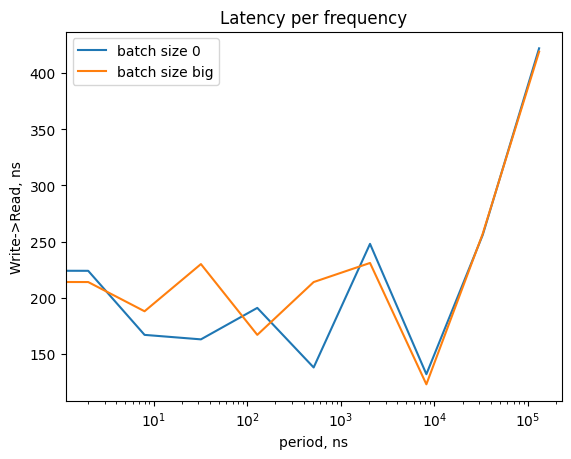

In [177]:
plt.plot(x, y_b0, label='batch size 0')
plt.plot(x, y_bb, label='batch size big')
plt.xlabel('period, ns')
plt.ylabel('Write->Read, ns')
plt.title('Latency per frequency')
plt.xscale("log")
plt.legend()

# Вывод
При периоде < 10^4ns имеем примерно равные значения задержки
Для дальнейшего рассмотрения оставляю period=0,10^4 для обоих BatchSize

In [171]:
sz = 10**5

y_b0_0 = []
y_b0_b = []
y_bb_0 = []
y_bb_b = []

for i in range(10):
    os.system(f'clang++ -std=c++17 -O3 writer.cpp -o writer')
    os.system(f'clang++ -std=c++17 -O3 reader.cpp -o reader')
    print(f'Running sz={sz}, ns={0}')
    run(sz, 0)
    w = fromFile('writer.txt')
    r = fromFile('reader.txt')
    res = r - w
    y_b0_0.append(np.percentile(res, 99))
    print(f'Running sz={sz}, ns={10**4}')
    run(sz, 10**4)
    w = fromFile('writer.txt')
    r = fromFile('reader.txt')
    res = r - w
    y_b0_b.append(np.percentile(res, 99))

    os.system(f'clang++ -std=c++17 -O3 writer.cpp -o writer')
    os.system(f'clang++ -std=c++17 -O3 reader.cpp -o reader -DBATCH_SIZE={batch_size}')
    print(f'Running sz={sz}, ns={0}')
    run(sz, 0)
    w = fromFile('writer.txt')
    r = fromFile('reader.txt')
    res = r - w
    y_bb_0.append(np.percentile(res, 99))
    print(f'Running sz={sz}, ns={10**4}')
    run(sz, 10**4)
    w = fromFile('writer.txt')
    r = fromFile('reader.txt')
    res = r - w
    y_bb_b.append(np.percentile(res, 99))

Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=100000, ns=0
Running sz=100000, ns=10000
Running sz=1

Text(0.5, 1.0, 'BatchSize = 0, Period = 0')

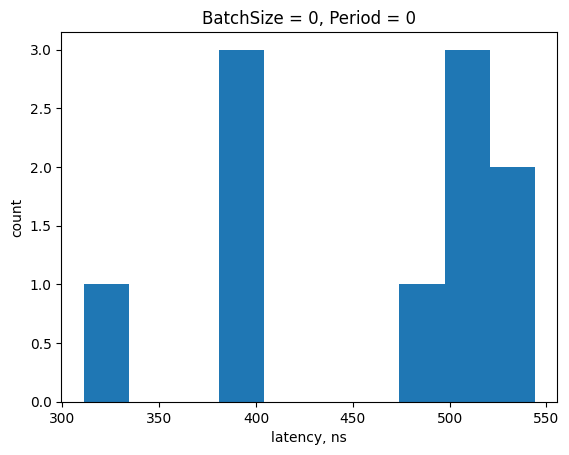

In [172]:
plt.hist(y_b0_0)
plt.ylabel('count')
plt.xlabel('latency, ns')
plt.title('BatchSize = 0, Period = 0')

Text(0.5, 1.0, 'BatchSize = 0, Period = 10^4ns')

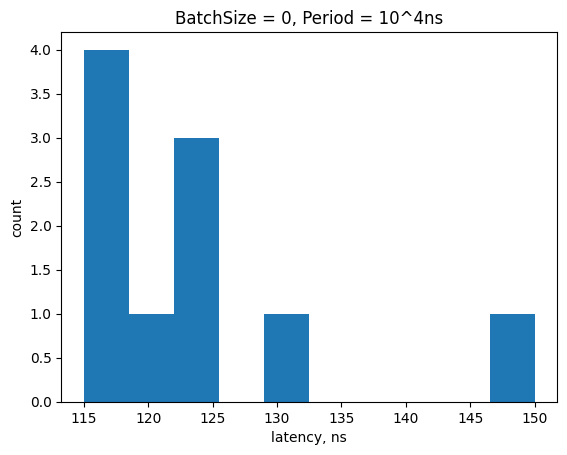

In [173]:
plt.hist(y_b0_b)
plt.ylabel('count')
plt.xlabel('latency, ns')
plt.title('BatchSize = 0, Period = 10^4ns')

Text(0.5, 1.0, 'BatchSize = RingBufferSize - eps, Period = 0')

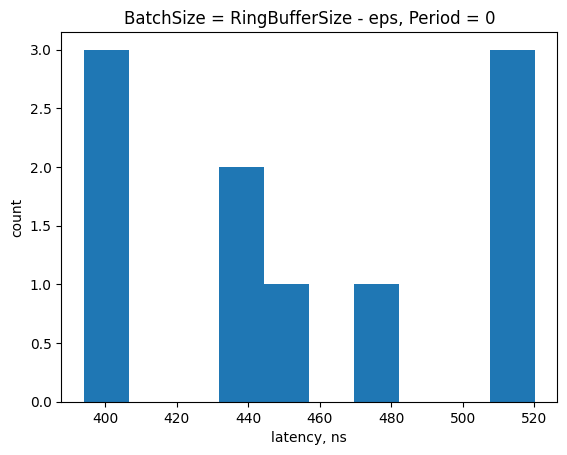

In [174]:
plt.hist(y_bb_0)
plt.ylabel('count')
plt.xlabel('latency, ns')
plt.title('BatchSize = RingBufferSize - eps, Period = 0')

Text(0.5, 1.0, 'BatchSize = RingBufferSize - eps, Period = 10^4ns')

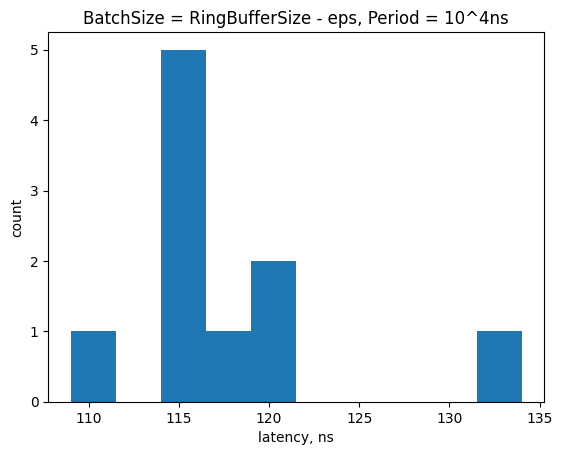

In [175]:
plt.hist(y_bb_b)
plt.ylabel('count')
plt.xlabel('latency, ns')
plt.title('BatchSize = RingBufferSize - eps, Period = 10^4ns')

# Вывод
Как итоговый вариант оставляю промежуток между записями в 10^4 и BatchSize близким к размеру всего буффера(1024 по умолчанию) - см последний график